# 2色のマルチカー塗装工場問題

[マルチカー塗装工場問題](https://arxiv.org/pdf/2109.07876) の目的は、自動車の製造工程において、塗装ラインでの色の切り替え回数を削減することです。この問題はNP困難な問題として知られています。このチュートリアルでは、2色のシナリオを考えます。

まず、使用する主要なライブラリをインストールし、インポートしましょう。

In [1]:
# !pip install qamomile[qiskit, quri_parts]

In [2]:
from collections import defaultdict
import random as rand

import jijmodeling as jm
import matplotlib.pyplot as plt
import numpy as np
import ommx.v1

import qamomile as qm
from qamomile.core.circuit.drawer import plot_quantum_circuit
from qamomile.core.converters.qaoa import QAOAConverter
import qamomile.qiskit as qm_qk

## 数理モデルの構築

2色で塗装する必要がある自動車の集合 $X = \{x_1, x_2, \dots, x_n\}$ が与えられており、各車両 $x_i$ は $0$ または $1$ のいずれかの色で塗装されるものとします（$i = 1, \dots, n$）。目的は、並べられた車列における隣接する車両間の色の切り替え回数（つまり $0$ から $1$、または $1$ から $0$ への変化）を最小化することです。

車列における色の切り替えの回数（コスト）は以下のように定式化されます：

$$
\text{min} \quad - \sum_{i=0}^{N-2} s_i s_{i+1}.
$$

ここで $-s_i \cdot s_{i+1}$ は隣接する車両の関係を表し、同じ色であれば $-1$、異なる色であれば $+1$ になります。すなわち、同じ色の方が低コストとなるため、合計を最小化することで色の切り替え回数を減らすことができます。

スピン変数 $s_i$ をバイナリ変数 $x_i$ に変換すると、以下のような式になります：

$$
\text{min} \quad -\sum_{i=0}^{N-2} (x_i - 0.5) \cdot (x_{i+1} - 0.5).
$$

この2色塗装工場問題においては、色の切り替えを最小限に抑えると同時に、特定の制約も満たす必要があります。本ノートブックでは、各車種（モデル数は $M$）ごとに、2色の車両が予定された台数通りに塗装されるという制約を考慮します。

この制約は以下のように表されます：

$$
 V_{i,m} \cdot x_i = W_m \quad ,\forall m \in \{0, \dots, M-1\}
$$

ここで、$V_{i,m}$ は各車両 $i$ がどのモデル $m$ に属するかを示すワンホットの2次元行列です。

まず、`JijModeling`を用いてこの問題をモデル化していきます。

In [3]:
def get_mcps_problem() -> jm.Problem:
    V = jm.Placeholder("V", ndim=2) # 車の投入順序を表す
    W = jm.Placeholder("W", ndim=1) # 各モデルごとの黒色の車の台数
    N = jm.Placeholder("N") # 車の総数
    M = jm.Placeholder("M") # 車のモデル数
    x = jm.BinaryVar("x", shape=(N,))
    i = jm.Element("i", belong_to=(0, N-1))
    j = jm.Element("j", belong_to=(0, N))
    m = jm.Element("m", belong_to=(0, M))

    problem = jm.Problem("MCPS") 
    problem += jm.sum([i], -(x[i] - 0.5) * (x[i+1] - 0.5))
    problem += jm.Constraint("n-hot", jm.sum([j], V[j][m] * x[j]) == W[m], forall=m)
    return problem
problem = get_mcps_problem()
problem

## インスタンスデータの準備

In [4]:
car_map = {
    0: "🚗",  # 赤い車
    1: "🚕",  # タクシー
    2: "🚙",  # SUV
    3: "🚓"   # パトカー
}

number_of_models = 4 
number_of_cars = 8
# 各モデルごとの黒色の車の台数
black_per_models = [1, 1, 1, 1]

# 4種類のモデルに属する8台の車を作成
cars = [0, 0, 1, 1, 2, 2, 3, 3] 
rand.shuffle(cars)
print(f"The order of car intake: {[car_map[car] for car in cars]}") 

# 車の投入順序を表す2次元配列を作成
cars_onehot = np.eye(number_of_models)[cars]
print([car_map[i] for i in range(4)])
print(cars_onehot)

The order of car intake: ['🚙', '🚙', '🚗', '🚗', '🚓', '🚓', '🚕', '🚕']
['🚗', '🚕', '🚙', '🚓']
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


## コンパイル済みインスタンスの作成
インスタンスとは、数式中の定数に実際の値を代入したものです。さまざまなアルゴリズムに変換する前に、`JijModeling.Interpreter`と`ommx.Instance`を使ってこのインスタンスを作成する必要があります。

In [5]:
data = {"V": cars_onehot, "W":  black_per_models, "N":  number_of_cars, "M": number_of_models}
interpreter = jm.Interpreter(data)
instance = interpreter.eval_problem(problem)

## Qamomileを用いたQAOA回路とハミルトニアンの生成
`Qamomile`は、コンパイル済みインスタンスからQAOA用の回路とハミルトニアンを生成するコンバータを提供しています。また、QUBOへの変換時に発生するパラメータを設定することも可能です。

まずはIsingハミルトニアンを生成します。これが完了すると、QAOAの量子回路とハミルトニアンも生成できます。

In [6]:
qaoa_converter = QAOAConverter(instance)
# Ising ハミルトニアンへのエンコード
qaoa_converter.ising_encode(multipliers={"n-hot": 3})
# QAOA 回路の取得
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=1)
# コストハミルトニアンの取得
qaoa_cost = qaoa_converter.get_cost_hamiltonian()

## QAOA回路の可視化

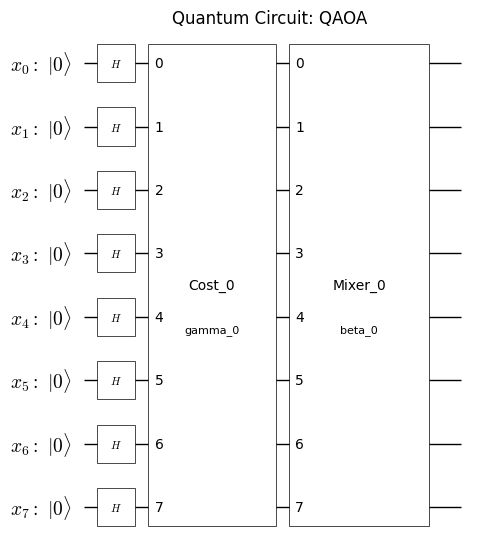

In [7]:
plot_quantum_circuit(qaoa_circuit)

## 取得したQAOA回路とハミルトニアンをQiskit向けに変換
まず、回路とハミルトニアンをQiskit用に変換します。

In [8]:
qk_transpiler = qm_qk.QiskitTranspiler()

# QAOA回路をQiskit用に変換する
qk_circuit = qk_transpiler.transpile_circuit(qaoa_circuit)
qk_hamiltonian = qk_transpiler.transpile_hamiltonian(qaoa_cost)

## QAOAの実行  
これで準備が整ったので、QAOAを実行します。ここでは、最適化アルゴリズムとしてScipyのCOBYLAを使用します。

In [9]:
import qiskit.primitives as qk_pr
import numpy as np
from scipy.optimize import minimize

cost_history = []
def cost_estimator(param_values):
    estimator = qk_pr.StatevectorEstimator()
    job = estimator.run([(qk_circuit, qk_hamiltonian, param_values)])
    result = job.result()[0]
    cost = result.data['evs']
    cost_history.append(cost)
    return cost

# Run QAOA optimization
result = minimize(
    cost_estimator,
    np.random.rand(2) * np.pi,
    method="COBYLA",
    options={"maxiter": 100},
)
print(result)

 message: Return from COBYLA because the objective function has been evaluated MAXFUN times.
 success: False
  status: 3
     fun: 1.0683050306062603
       x: [ 1.178e+00  1.682e+00]
    nfev: 100
   maxcv: 0.0


コスト関数の変化も確認してみましょう。

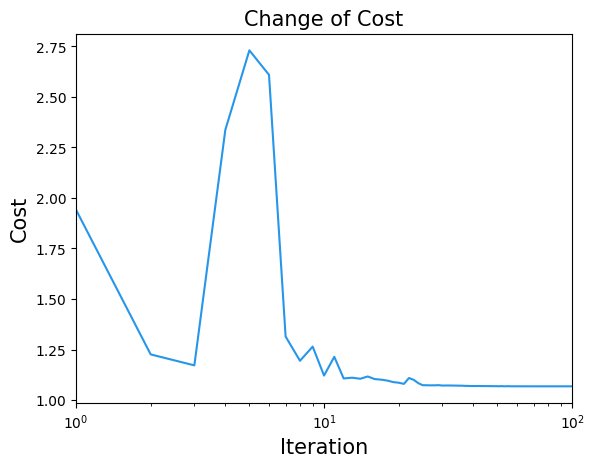

In [10]:
plt.title("Change of Cost", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.xscale("log")
plt.xlim(1, result.nfev)
plt.plot(cost_history, label="Cost", color="#2696EB")
plt.show()

QAOAのパラメータが得られたので、それらを用いてサンプリングを行いましょう。

In [11]:
# 最適化されたQAOA回路を実行する
sampler = qk_pr.StatevectorSampler()
qk_circuit.measure_all()
job = sampler.run([(qk_circuit, result.x)], shots=1000)
job_result = job.result()[0]
qaoa_counts = job_result.data["meas"]

## 結果の評価  
塗装順の最適解を特定することができます。

In [12]:
paint_map = {
    1: "⚫",  # 黒の塗装 
    0: ""    # 空文字
}

sampleset = qaoa_converter.decode(qk_transpiler, job_result.data["meas"])

best_sample = sampleset.best_feasible_unrelaxed
best_values = best_sample.extract_decision_variables("x")

values = [best_values.get((i,)) for i in range(8)]

print("The order of car intake: ", [car_map[car] for car in cars])
print("Color separation: ", [paint_map[value] for value in values])

The order of car intake:  ['🚙', '🚙', '🚗', '🚗', '🚓', '🚓', '🚕', '🚕']
Color separation:  ['⚫', '', '', '⚫', '⚫', '', '', '⚫']


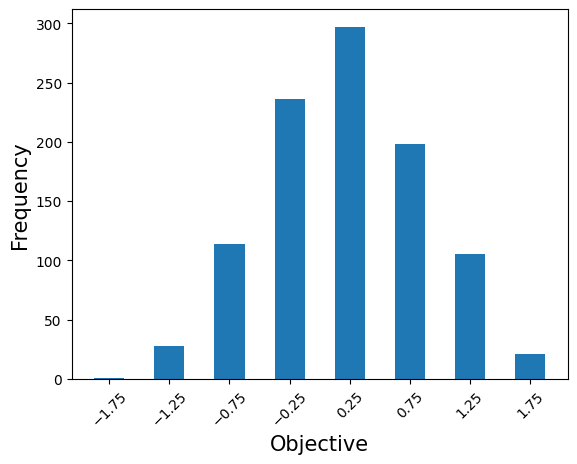

In [13]:
sampleset = qaoa_converter.decode(qk_transpiler, job_result.data["meas"])

# 各エネルギー値の出現回数を蓄積するための辞書を初期化
frequencies = defaultdict(int)

# Create a dictionary to group energies and count their frequencies
from collections import defaultdict
energy_freq = defaultdict(int)

for sample_id in sampleset.sample_ids:
    sample = sampleset.get(sample_id)
    energy = round(sample.objective, ndigits=3)
    energy_freq[energy] += 1

frequencies = energy_freq

plt.bar(frequencies.keys(), frequencies.values(), width=0.25)
plt.xticks(sorted(np.array(list(frequencies.keys()))), rotation=45)
plt.xlabel('Objective', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

## 古典的アルゴリズムによる評価
全探索による最良コストとの比較を行います。

In [14]:
def eval_mcps_state(cars, black_per_models, state, num_cars, num_models):
  cnt = [0] * num_models
  for i in range(num_cars):
    cnt[cars[i]] += state[i]
  for i in range(num_models):
    if black_per_models[i] != cnt[i]:
      return None
  score = 0
  for i in range(num_cars-1):
    if state[i] != state[i+1]:
      score += 1
  return score

def best_cost_mcps(cars, black_per_models, num_cars, num_models):
  best_score = 1e9
  for i in range(2**num_cars):
    state = [0] * num_cars
    for j in range(num_cars):
      if i & (2**j) != 0:
        state[j] = 1
    score = eval_mcps_state(cars, black_per_models, state, num_cars, num_models)
    if not(score is None):
      best_score = min(best_score, score)
  return best_score

exact_score = best_cost_mcps(cars, black_per_models, number_of_cars, number_of_models)
qaoa_score = eval_mcps_state(cars, black_per_models, values, number_of_cars, number_of_models)
print("exact solution: ", exact_score)
print("solution using QAOA: ", qaoa_score)

exact solution:  4
solution using QAOA:  4
